# Load Libraries

In [213]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from IPython.core.debugger import set_trace
from scipy.stats import norm, spearmanr, pearsonr
from tqdm import tqdm
from scipy.spatial.distance import squareform, pdist
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS
from scipy.stats import poisson, randint, zipf, triang
from Levenshtein import distance, jaro, jaro_winkler
from sklearn.linear_model import LinearRegression
import re

# Load and Visualize LLM Number Similarity

In [214]:
def log_linear_distance(num1, num2, eps_reg=0.0001):
    return np.abs(np.log(num1 + eps_reg) - np.log(num2 + eps_reg))

In [215]:
def log_linear_similarity(num1, num2, eps_reg=0.0001):
    return np.exp(-log_linear_distance(num1, num2, eps_reg))

In [216]:
MAX_NUM = 999
all_strings = [str(i) for i in range(0, MAX_NUM + 1)]

dist_mat_lev = np.zeros((MAX_NUM + 1, MAX_NUM + 1))
dist_mat_lin = np.zeros((MAX_NUM + 1, MAX_NUM + 1))
for i in range(MAX_NUM + 1):
    for j in range(MAX_NUM + 1):
        dist_mat_lev[i,j] = distance(all_strings[i], all_strings[j])
        # dist_mat_lin[i,j] = abs(int(all_strings[i]) - int(all_strings[j]))
        # dist_mat_lin[i,j] = 1 - np.exp(-abs(np.log(int(all_strings[i]) + eps_reg) - np.log(int(all_strings[j]) + eps_reg)))
        dist_mat_lin[i,j] = 1 - np.exp(-log_linear_distance(int(all_strings[i]), int(all_strings[j])))

sim_mat_lev = 1 - dist_mat_lev / np.max(dist_mat_lev)
sim_mat_lin = 1 - dist_mat_lin / np.max(dist_mat_lin)

In [217]:
sim_mat_gpt = np.load("all_models/numbers_0_to_1999_batchAPI-0-gpt-4o-batch-0-1-BatchAPI.npy")
sim_mat_gpt = (sim_mat_gpt + np.transpose(sim_mat_gpt)) / 2

sim_mat_gpt_int = np.load("all_models/numbers_0_to_999_int_batchAPI-0-gpt-4o-batch-0-1-BatchAPI.npy")
sim_mat_gpt_str = np.load("all_models/numbers_0_to_999_str_batchAPI-0-gpt-4o-batch-0-1-BatchAPI.npy")
sim_mat_gpt_int = (sim_mat_gpt_int + np.transpose(sim_mat_gpt_int)) / 2
sim_mat_gpt_str = (sim_mat_gpt_str + np.transpose(sim_mat_gpt_str)) / 2

In [218]:
other_models = np.load("all_models/default.npy", allow_pickle=True).item()
other_models_int = np.load("all_models/int.npy", allow_pickle=True).item()
other_models_str = np.load("all_models/str.npy", allow_pickle=True).item()

In [219]:
MODEL_TO_MARKER = {
    "GPT-4o": "o",
    "Llama-8b": "d",
    "Llama-70b": "s",
    "DeepSeek": "v",
    "Claude": "P",
    "Mixtral": "*"
}

MODEL_TO_COLOR = {
    "GPT-4o": "tab:blue",
    "Llama-8b": "tab:green",
    "Llama-70b": "tab:red",
    "DeepSeek": "tab:orange",
    "Claude": "tab:cyan",
    "Mixtral": "tab:purple"
}

all_sim_mats = {
    "GPT-4o": sim_mat_gpt.copy()[0:(MAX_NUM + 1), 0:(MAX_NUM + 1)].copy(),
    "DeepSeek": (other_models['DeepSeek-V3'] + np.transpose(other_models['DeepSeek-V3'])) / 2,
    "Llama-8b": (other_models['llama-3.1-8b-instruct'] + np.transpose(other_models['llama-3.1-8b-instruct'])) / 2,
    "Llama-70b": (other_models['llama-3.1-70b-instruct'] + np.transpose(other_models['llama-3.1-70b-instruct'])) / 2,
    "Claude": (other_models['claude-3.5-sonnet'] + np.transpose(other_models['claude-3.5-sonnet'])) / 2,
    "Mixtral": (other_models['mixtral-8x22b-instruct'] + np.transpose(other_models['mixtral-8x22b-instruct'])) / 2,
    "Levenshtein": sim_mat_lev.copy(),
    "Linear": sim_mat_lin.copy()
}

all_sim_mats_int = {
    "GPT-4o": sim_mat_gpt_int.copy(),
    "DeepSeek": (other_models_int['DeepSeek-V3'] + np.transpose(other_models_int['DeepSeek-V3'])) / 2,
    "Llama-8b": (other_models_int['llama-3.1-8b-instruct'] + np.transpose(other_models_int['llama-3.1-8b-instruct'])) / 2,
    "Llama-70b": (other_models_int['llama-3.1-70b-instruct'] + np.transpose(other_models_int['llama-3.1-70b-instruct'])) / 2,
    "Claude": (other_models_int['claude-3.5-sonnet'] + np.transpose(other_models_int['claude-3.5-sonnet'])) / 2,
    "Mixtral": (other_models_int['mixtral-8x22b-instruct'] + np.transpose(other_models_int['mixtral-8x22b-instruct'])) / 2,
    "Levenshtein": sim_mat_lev.copy(),
    "Linear": sim_mat_lin.copy()
}

all_sim_mats_str = {
    "GPT-4o": sim_mat_gpt_str.copy(),
    "DeepSeek": (other_models_str['DeepSeek-V3'] + np.transpose(other_models_str['DeepSeek-V3'])) / 2,
    "Llama-8b": (other_models_str['llama-3.1-8b-instruct'] + np.transpose(other_models_str['llama-3.1-8b-instruct'])) / 2,
    "Llama-70b": (other_models_str['llama-3.1-70b-instruct'] + np.transpose(other_models_str['llama-3.1-70b-instruct'])) / 2,
    "Claude": (other_models_str['claude-3.5-sonnet'] + np.transpose(other_models_str['claude-3.5-sonnet'])) / 2,
    "Mixtral": (other_models_str['mixtral-8x22b-instruct'] + np.transpose(other_models_str['mixtral-8x22b-instruct'])) / 2,
    "Levenshtein": sim_mat_lev.copy(),
    "Linear": sim_mat_lin.copy()
}

for key in all_sim_mats.keys(): # set diagonal to 1, only for visualization purposes
    np.fill_diagonal(all_sim_mats[key], 1)
    np.fill_diagonal(all_sim_mats_int[key], 1)
    np.fill_diagonal(all_sim_mats_str[key], 1)

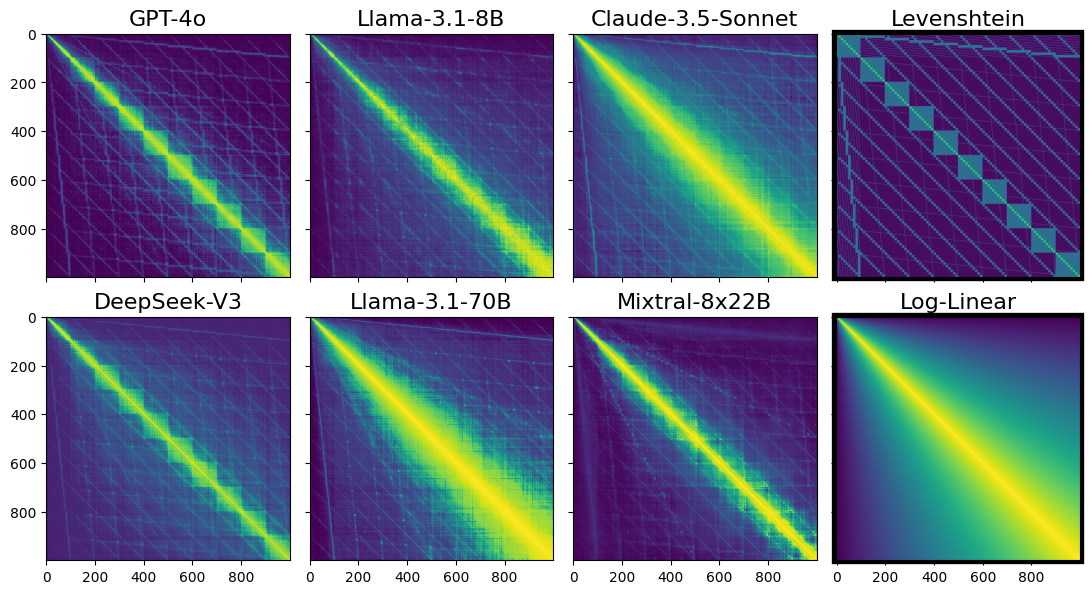

In [220]:
FULL_NAMES = {
    "GPT-4o": "GPT-4o",
    "Llama-8b": "Llama-3.1-8B",
    "Llama-70b": "Llama-3.1-70B",
    "DeepSeek": "DeepSeek-V3",
    "Claude": "Claude-3.5-Sonnet",
    "Mixtral": "Mixtral-8x22B",
    "Levenshtein": "Levenshtein",
    "Linear": "Log-Linear"
}

SHAPE = (2, 4)
fig, axs = plt.subplots(SHAPE[0], SHAPE[1], figsize=(11,6), sharex=True, sharey=True)

for i, key in enumerate(all_sim_mats.keys()):
    idx1, idx2 = np.unravel_index(i, SHAPE, order='F')
    axs[idx1, idx2].imshow(all_sim_mats[key])
    axs[idx1, idx2].set_title(FULL_NAMES[key], fontsize=16)

axs[0,-1].patch.set_linewidth(6)
axs[0,-1].patch.set_edgecolor('black')
axs[1,-1].patch.set_linewidth(6)
axs[1,-1].patch.set_edgecolor('black')

plt.tight_layout()
# plt.savefig("final_plots/all_simmats_v3.pdf",dpi=300)

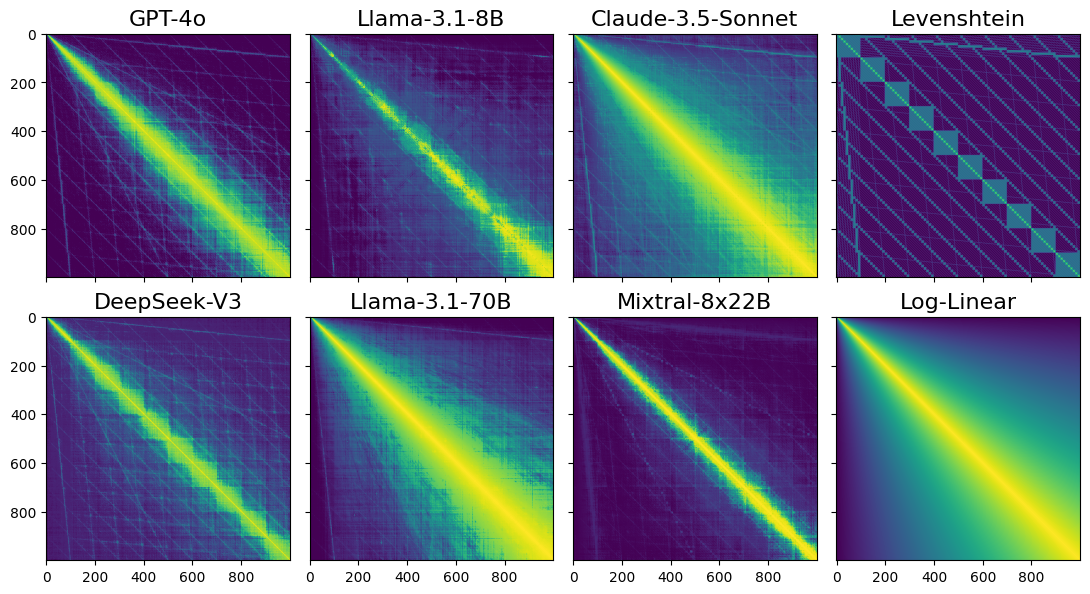

In [221]:
SHAPE = (2, 4)
fig, axs = plt.subplots(SHAPE[0], SHAPE[1], figsize=(11,6), sharex=True, sharey=True)

for i, key in enumerate(all_sim_mats_int.keys()):
    idx1, idx2 = np.unravel_index(i, SHAPE, order='F')
    axs[idx1, idx2].imshow(all_sim_mats_int[key])
    axs[idx1, idx2].set_title(FULL_NAMES[key], fontsize=16)

plt.tight_layout()
# plt.savefig("final_plots/all_simmats_int_v3.pdf",dpi=300)

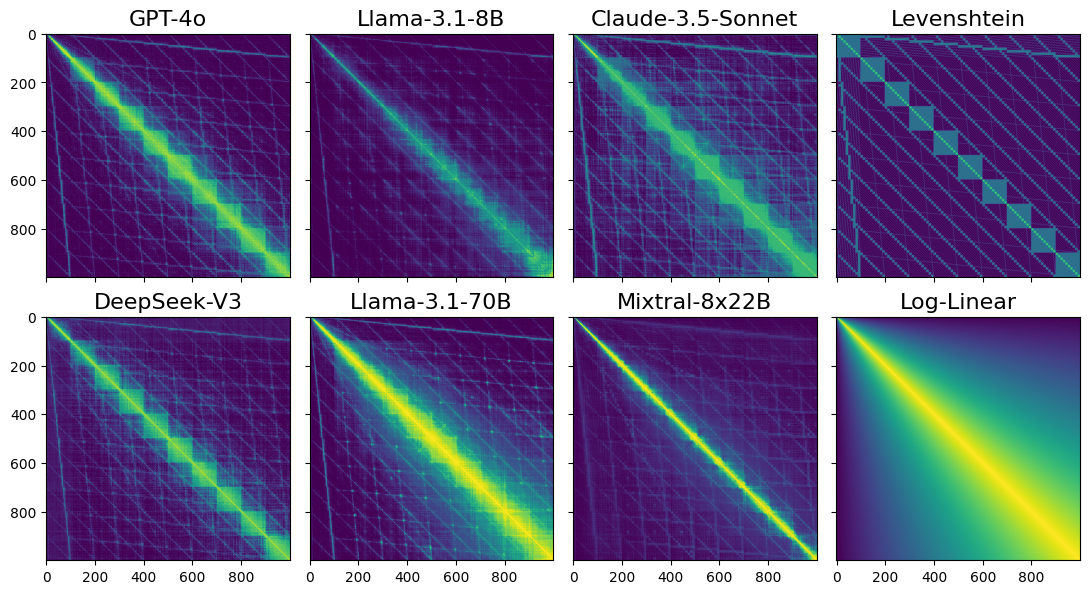

In [222]:
SHAPE = (2, 4)
fig, axs = plt.subplots(SHAPE[0], SHAPE[1], figsize=(11,6), sharex=True, sharey=True)

for i, key in enumerate(all_sim_mats_str.keys()):
    idx1, idx2 = np.unravel_index(i, SHAPE, order='F')
    axs[idx1, idx2].imshow(all_sim_mats_str[key])
    axs[idx1, idx2].set_title(FULL_NAMES[key], fontsize=16)

plt.tight_layout()
# plt.savefig("final_plots/all_simmats_str.pdf",dpi=300)

### Merged str vs. int plot

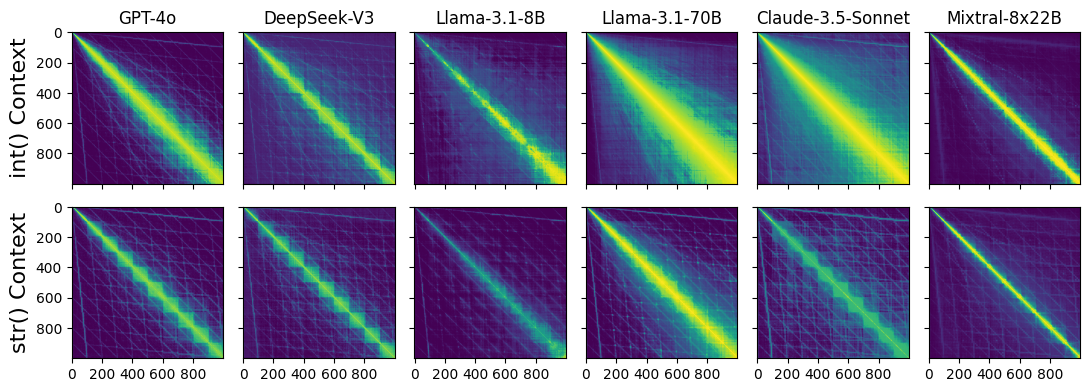

In [263]:
SHAPE = (2, 6)
fig, axs = plt.subplots(SHAPE[0], SHAPE[1], figsize=(11,4), sharex=True, sharey=True)

keys = [key for key in all_sim_mats_int.keys() if ((key != "Levenshtein") and (key != "Linear"))]

for i, key in enumerate(keys):
    # idx1, idx2 = np.unravel_index(i, SHAPE, order='F')
    axs[0, i].imshow(all_sim_mats_int[key])
    axs[0, i].set_title(FULL_NAMES[key], fontsize=12)
    axs[0, i].set_xticks(np.arange(0,1000,200))

for i, key in enumerate(keys):
    # idx1, idx2 = np.unravel_index(i, SHAPE, order='F')
    axs[1, i].imshow(all_sim_mats_str[key])
    # axs[1, i].set_title(key, fontsize=16)

axs[0, 0].set_ylabel("int() Context", fontsize=16)
axs[1, 0].set_ylabel("str() Context", fontsize=16)

plt.tight_layout()
# plt.savefig("final_plots/all_simmats_int_str_merged.pdf",dpi=300)

# Regress Against Main Metrics

In [224]:
def get_metric_regressors(sim_mat, lev_sim_mat1, lin_sim_mat2, jump=200):
    fraction_to_include = np.array(list(np.arange(100, MAX_NUM + 1, jump)) + [MAX_NUM + 1])
    rsq_list = []
    coef_lev = []
    coef_lin = []
    rsq_solo_lev = []
    rsq_solo_lin = []
    
    for fti in fraction_to_include:
        v_llm = squareform(sim_mat[0:fti,0:fti], checks=False)
        v_lev = squareform(lev_sim_mat1[0:fti,0:fti], checks=False)
        v_lin = squareform(lin_sim_mat2[0:fti,0:fti], checks=False)
        
        v_llm = (v_llm - np.mean(v_llm)) / np.std(v_llm)
        v_lev = (v_lev - np.mean(v_lev)) / np.std(v_lev)
        v_lin = (v_lin - np.mean(v_lin)) / np.std(v_lin)
    
        X = np.vstack([v_lin, v_lev]).transpose()
        X_lin = v_lin.reshape(-1,1)
        X_lev = v_lev.reshape(-1,1)
        y = v_llm.copy()
        reg = LinearRegression(fit_intercept=True, positive=True).fit(X, y)
        reg_lin = LinearRegression(fit_intercept=True, positive=True).fit(X_lin, y)
        reg_lev = LinearRegression(fit_intercept=True, positive=True).fit(X_lev, y)
        
        y_pred = reg.predict(X)
        rsq_list.append(reg.score(X,y))
        
        rsq_solo_lin.append(reg_lin.score(X_lin, y))
        rsq_solo_lev.append(reg_lev.score(X_lev, y))
        
        coef_lin.append(reg.coef_[0])
        coef_lev.append(reg.coef_[1])
    
    return {
        "rsq_list": rsq_list.copy(),
        "rsq_solo_lin": rsq_solo_lin.copy(),
        "rsq_solo_lev": rsq_solo_lev.copy(),
        "coef_lin": coef_lin.copy(),
        "coef_lev": coef_lev.copy()
    }

def get_metric_regressors_bootstrap(sim_mat, lev_sim_mat1, lin_sim_mat2, nboots=1000):
    rsq_list = []
    coef_lev = []
    coef_lin = []
    rsq_solo_lev = []
    rsq_solo_lin = []

    v_llm = squareform(sim_mat, checks=False)
    v_lev = squareform(lev_sim_mat1, checks=False)
    v_lin = squareform(lin_sim_mat2, checks=False)
    
    v_llm = (v_llm - np.mean(v_llm)) / np.std(v_llm)
    v_lev = (v_lev - np.mean(v_lev)) / np.std(v_lev)
    v_lin = (v_lin - np.mean(v_lin)) / np.std(v_lin)

    for boot in range(nboots):
        boot_idxs = np.random.choice(np.arange(len(v_llm)), size=len(v_llm))
        v_llm_boot = v_llm[boot_idxs]
        v_lev_boot = v_lev[boot_idxs]
        v_lin_boot = v_lin[boot_idxs]
        
        X = np.vstack([v_lin_boot, v_lev_boot]).transpose()
        X_lin = v_lin_boot.reshape(-1,1)
        X_lev = v_lev_boot.reshape(-1,1)
        y = v_llm_boot.copy()
        
        reg = LinearRegression(fit_intercept=True, positive=True).fit(X, y)
        reg_lin = LinearRegression(fit_intercept=True, positive=True).fit(X_lin, y)
        reg_lev = LinearRegression(fit_intercept=True, positive=True).fit(X_lev, y)
        
        y_pred = reg.predict(X)
        rsq_list.append(reg.score(X,y))
        
        rsq_solo_lin.append(reg_lin.score(X_lin, y))
        rsq_solo_lev.append(reg_lev.score(X_lev, y))
        
        coef_lin.append(reg.coef_[0])
        coef_lev.append(reg.coef_[1])
    
    return {
        "rsq_list": rsq_list.copy(),
        "rsq_solo_lin": rsq_solo_lin.copy(),
        "rsq_solo_lev": rsq_solo_lev.copy(),
        "coef_lin": coef_lin.copy(),
        "coef_lev": coef_lev.copy()
    }

In [225]:
all_metrics = {}
for key in all_sim_mats.keys():
    if key in ["Levenshtein", "Linear"]:
        continue
    all_metrics[key] = get_metric_regressors(all_sim_mats[key], all_sim_mats["Levenshtein"], all_sim_mats["Linear"])
    
all_metrics_int = {}
for key in all_sim_mats_int.keys():
    if key in ["Levenshtein", "Linear"]:
        continue
    all_metrics_int[key] = get_metric_regressors(all_sim_mats_int[key], all_sim_mats_int["Levenshtein"], all_sim_mats_int["Linear"])

all_metrics_str = {}
for key in all_sim_mats_str.keys():
    if key in ["Levenshtein", "Linear"]:
        continue
    all_metrics_str[key] = get_metric_regressors(all_sim_mats_str[key], all_sim_mats_str["Levenshtein"], all_sim_mats_str["Linear"])

In [226]:
all_metrics_boots = {}
for key in tqdm(all_sim_mats.keys()):
    if key in ["Levenshtein", "Linear"]:
        continue
    all_metrics_boots[key] = get_metric_regressors_bootstrap(all_sim_mats[key], all_sim_mats["Levenshtein"], all_sim_mats["Linear"])
    
all_metrics_int_boots = {}
for key in tqdm(all_sim_mats_int.keys()):
    if key in ["Levenshtein", "Linear"]:
        continue
    all_metrics_int_boots[key] = get_metric_regressors_bootstrap(all_sim_mats_int[key], all_sim_mats_int["Levenshtein"], all_sim_mats_int["Linear"])

all_metrics_str_boots = {}
for key in tqdm(all_sim_mats_str.keys()):
    if key in ["Levenshtein", "Linear"]:
        continue
    all_metrics_str_boots[key] = get_metric_regressors_bootstrap(all_sim_mats_str[key], all_sim_mats_str["Levenshtein"], all_sim_mats_str["Linear"])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:45<00:00, 20.69s/it]


In [227]:
# np.save("data/regression_bootstrap_default_loglin.npy", all_metrics_boots, allow_pickle=True)
# np.save("data/regression_bootstrap_int_loglin.npy", all_metrics_int_boots, allow_pickle=True)
# np.save("data/regression_bootstrap_str_loglin.npy", all_metrics_str_boots, allow_pickle=True)

In [286]:
mean_boots = np.mean(np.vstack([all_metrics_int_boots[key]["rsq_list"] for key in all_metrics_int_boots.keys()]), axis=0)
# np.mean(mean_boots) - 1.96 * np.std(mean_boots)
# np.mean(mean_boots) + 1.96 * np.std(mean_boots)
# np.mean(mean_boots)

0.7223941209548241

In [288]:
mean_boots = np.mean(np.vstack([all_metrics_int_boots[key]["rsq_solo_lin"] for key in all_metrics_int_boots.keys()]), axis=0)
# np.mean(mean_boots) - 1.96 * np.std(mean_boots)
# np.mean(mean_boots) + 1.96 * np.std(mean_boots)
# np.mean(mean_boots)

0.6456753829913455

In [290]:
mean_boots = np.mean(np.vstack([all_metrics_int_boots[key]["rsq_solo_lev"] for key in all_metrics_int_boots.keys()]), axis=0)
# np.mean(mean_boots) - 1.96 * np.std(mean_boots)
# np.mean(mean_boots) + 1.96 * np.std(mean_boots)
# np.mean(mean_boots)

0.15818227086851513

## Merged default vs. int vs. str plot

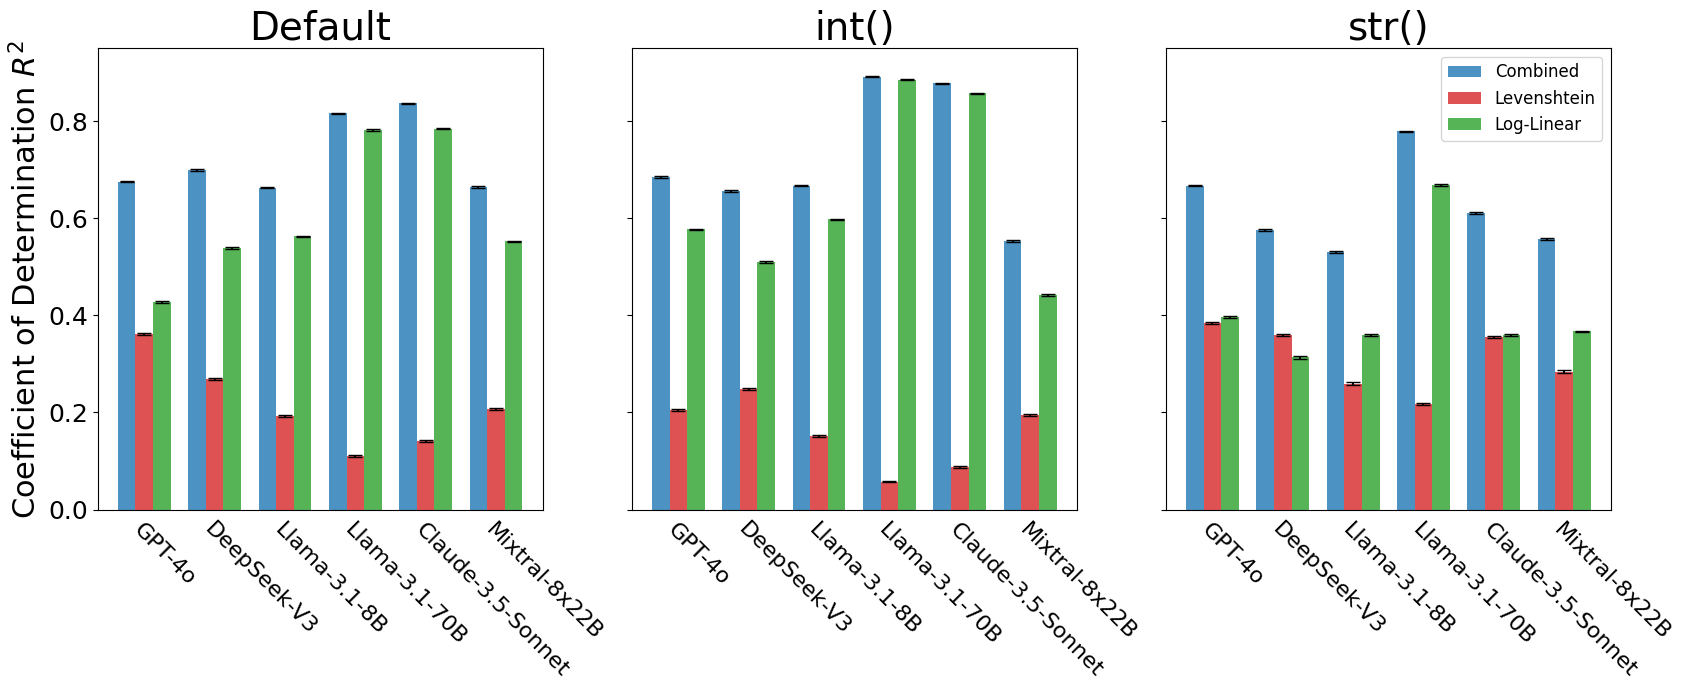

In [230]:
width = 0.25

fig, axs = plt.subplots(1, 3 ,figsize=(17, 7),sharey=True)

metric_list = [
    all_metrics_boots,
    all_metrics_int_boots,
    all_metrics_str_boots
]

for i, current_metrics in enumerate(metric_list):
    all_model_keys = [FULL_NAMES[key] for key in current_metrics.keys()]
    all_rsq = [np.mean(current_metrics[key]["rsq_list"]) for key in current_metrics.keys()]
    all_rsq_solo_lin = [np.mean(current_metrics[key]["rsq_solo_lin"]) for key in current_metrics.keys()]
    all_rsq_solo_lev = [np.mean(current_metrics[key]["rsq_solo_lev"]) for key in current_metrics.keys()]

    all_rsq_ci = [1.96 * np.std(current_metrics[key]["rsq_list"]) for key in current_metrics.keys()]
    all_rsq_solo_lin_ci = [1.96 * np.std(current_metrics[key]["rsq_solo_lin"]) for key in current_metrics.keys()]
    all_rsq_solo_lev_ci = [1.96 * np.std(current_metrics[key]["rsq_solo_lev"]) for key in current_metrics.keys()]
    
    loc_vals = np.arange(len(all_rsq))
    
    weight_counts_rsq_full = np.array(all_rsq)
    weight_counts_rsq_lev = np.array(all_rsq_solo_lev)
    weight_counts_rsq_lin = np.array(all_rsq_solo_lin)
    
    axs[i].bar(loc_vals, weight_counts_rsq_full, yerr = all_rsq_ci,
            align='center', alpha=0.8, ecolor='black', capsize=5, width=width, label="Combined", color="tab:blue")
    axs[i].set_xticks(np.array(loc_vals) + width / 2);
    
    axs[i].bar(loc_vals + width, weight_counts_rsq_lev, yerr = all_rsq_solo_lev_ci,
            align='center', alpha=0.8, ecolor='black', capsize=5, width=width, label="Levenshtein", color="tab:red")
    
    axs[i].bar(loc_vals + 2 * width, weight_counts_rsq_lin, yerr = all_rsq_solo_lin_ci,
            align='center', alpha=0.8, ecolor='black', capsize=5, width=width, label="Log-Linear", color="tab:green")
    
    labels = all_model_keys
    axs[i].set_xticks(np.array(loc_vals) + width);
    axs[i].xaxis.set_ticks_position('none')
    axs[i].tick_params(axis="both", labelsize=18)
    axs[i].set_xticklabels(labels, rotation=-45, ha='left', rotation_mode='anchor', fontsize=16);
    axs[i].set_ylim([0,0.95])

axs[0].set_ylabel(r"Coefficient of Determination $R^2$", fontsize=22)
axs[2].legend(ncol=1, fontsize=12, loc="upper right")
axs[0].set_title("Default", fontsize=28)
axs[1].set_title("int()", fontsize=28)
axs[2].set_title("str()", fontsize=28)

plt.tight_layout()

# plt.savefig("final_plots/r_squared_combined_loglin.pdf")

# Triplet Judgment Metrics

In [231]:
NSIZE = 3
NUM_TRIPLETS = 10000

# def get_lin_nn(v_probe, v_option1, v_option2):
#     if abs(v_probe - v_option1) < abs(v_probe - v_option2):
#         return 0
#     elif abs(v_probe - v_option1) > abs(v_probe - v_option2):
#         return 1
#     else:
#         return -1

def get_lin_nn(v_probe, v_option1, v_option2):
    if log_linear_distance(v_probe, v_option1) < log_linear_distance(v_probe, v_option2):
        return 0
    elif log_linear_distance(v_probe, v_option1) > log_linear_distance(v_probe, v_option2):
        return 1
    else:
        return -1

def get_lev_nn(v_probe, v_option1, v_option2):
    if distance(v_probe, v_option1) < distance(v_probe, v_option2):
        return 0
    elif distance(v_probe, v_option1) > distance(v_probe, v_option2):
        return 1
    else:
        return -1

In [232]:
close_triplet_list = np.load("data/triplets_close_3_digits.npy")
close_triplet_list

array([[473, 373, 415],
       [785, 685, 791],
       [672, 572, 698],
       ...,
       [885, 785, 841],
       [486, 386, 495],
       [458, 358, 422]])

In [233]:
# remove duplication in probe triplets

triplet_item_list = []
for i in range(close_triplet_list.shape[0]):
    item = close_triplet_list[i,:]
    triplet_item_list.append(str(item[0]) + "_" + str(item[1]) + "_" + str(item[2]))
    
triplet_item_list = np.array(triplet_item_list)
unique_item_list, reduction_idxs = np.unique(triplet_item_list, return_index = True) 

In [234]:
len(unique_item_list)

6474

### Medical Context (3 digits)

In [235]:
llm_triplet_dict_med = {}

gpt_ans = np.load("all_models/number_triplets_3dig_closeones_concentration-0-gpt-4o-0-1.npy")
gpt_ans_r = np.load("all_models/number_triplets_3dig_closeones_concentration_flipped-0-gpt-4o-0-1.npy")
gpt_ans = [int(t) for t in gpt_ans]
gpt_ans_r = [int(t) for t in gpt_ans_r]

other_triplets_med = np.load("all_models/medical_triplets_concentration_similar.npy", allow_pickle=True).item()
other_triplets_med_r = np.load("all_models/medical_triplets_concentration_similar_flipped.npy", allow_pickle=True).item()

KEY_TO_TITLE = {
    "llama-3.1-8b-instruct-turbo": "Llama-8b",
    "llama-3.1-70b-instruct-turbo": "Llama-70b",
    "DeepSeek-V3": "DeepSeek",
    "claude-3.5-sonnet": "Claude",
    "mixtral-8x22b-instruct": "Mixtral",
}

llm_triplet_dict_med["GPT-4o"] = np.array(gpt_ans.copy()).astype(int)

for key in KEY_TO_TITLE.keys():
    current_model = other_triplets_med[key]
    processed_list = []
    
    for i in range(current_model.shape[0]):
        processed_list.append(re.findall(r'\d+', str(current_model[i,-1]))[0])
    
    llm_triplet_dict_med[KEY_TO_TITLE[key]] = np.array(processed_list).astype(int)

llm_triplet_dict_med["GPT-4o (Rev.)"] = np.array(gpt_ans_r.copy()).astype(int)

for key in KEY_TO_TITLE.keys():
    current_model = other_triplets_med_r[key]
    processed_list = []
    
    for i in range(current_model.shape[0]):
        processed_list.append(re.findall(r'\d+', str(current_model[i,-1]))[0])
    
    llm_triplet_dict_med[KEY_TO_TITLE[key] + " (Rev.)"] = np.array(processed_list).astype(int)


llm_triplet_dict_med

{'GPT-4o': array([415, 791, 698, ..., 841, 495, 422]),
 'Llama-8b': array([415, 791, 572, ..., 841, 386, 422]),
 'Llama-70b': array([415, 791, 572, ..., 841, 495, 422]),
 'DeepSeek': array([415, 791, 698, ..., 841, 495, 422]),
 'Claude': array([415, 791, 698, ..., 841, 495, 422]),
 'Mixtral': array([415, 791, 698, ..., 841, 495, 422]),
 'GPT-4o (Rev.)': array([415, 791, 698, ..., 841, 495, 422]),
 'Llama-8b (Rev.)': array([373, 791, 572, ..., 841, 386, 422]),
 'Llama-70b (Rev.)': array([415, 791, 698, ..., 841, 495, 422]),
 'DeepSeek (Rev.)': array([415, 791, 698, ..., 841, 495, 422]),
 'Claude (Rev.)': array([415, 791, 698, ..., 841, 495, 422]),
 'Mixtral (Rev.)': array([415, 791, 698, ..., 841, 495, 422])}

In [236]:
cond_results_med = {}

for s, cond in enumerate(llm_triplet_dict_med.keys()):
    triplet_stimuli = np.load("data/triplets_close_3_digits.npy") # (probe, option1, option2)
    llm_triplet_judgments = llm_triplet_dict_med[cond]

    consistency_list = []
    
    for i in range(len(llm_triplet_judgments)):
        probe = int(triplet_stimuli[i][0])
        opts = [int(triplet_stimuli[i][1]), int(triplet_stimuli[i][2])]
        try:
            llm_answer = int(llm_triplet_judgments[i])
        except:
            consistency_list.append("none")
            continue
    
        nn_lin = opts[get_lin_nn(probe, opts[0], opts[1])]
        nn_lev = opts[get_lev_nn(str(probe), str(opts[0]), str(opts[1]))]

        if llm_answer in opts:
            if llm_answer == nn_lin:
                consistency_list.append("lin")
            elif llm_answer == nn_lev:
                consistency_list.append("lev")
            else:
                consistency_list.append("none")
        else:
            consistency_list.append("none")

    cond_results_med[cond] = consistency_list.copy()

In [237]:
triplet_fraction_summary_med = {}
for key in cond_results_med.keys():
    triplet_fraction_summary_med[key] = {}
    current = np.array(cond_results_med[key])[reduction_idxs] # remove duplication in triplets
    triplet_fraction_summary_med[key]["Linear"] = np.sum(current == "lin") / float(len(current))
    triplet_fraction_summary_med[key]["Levenshtein"] = np.sum(current == "lev") / float(len(current))
    triplet_fraction_summary_med[key]["Neither"] = np.sum(current == "none") / float(len(current))

/var/folders/87/72lf17fn1js83yb3myn2rz1h0000gq/T/ipykernel_11710/3338263394.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(conditions, rotation=-45, ha='left', rotation_mode='anchor', fontsize=12)


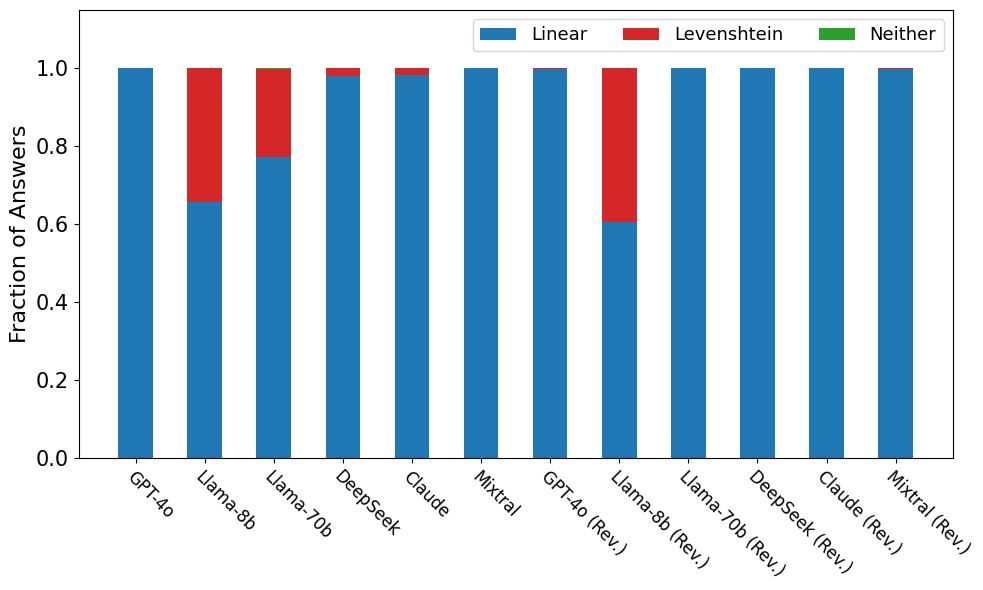

In [238]:
conditions = [key for key in triplet_fraction_summary_med.keys()]

weight_counts = {
    "Linear": np.array([triplet_fraction_summary_med[key]["Linear"] for key in conditions]),
    "Levenshtein": np.array([triplet_fraction_summary_med[key]["Levenshtein"] for key in conditions]),
    "Neither": np.array([triplet_fraction_summary_med[key]["Neither"] for key in conditions])
}

TYPE_TO_COLOR = {
    "Linear": "tab:blue",
    "Levenshtein": "tab:red",
    "Neither": "tab:green"
    
}

width = 0.5

fig, ax = plt.subplots(figsize=(10, 6))
bottom = np.zeros(len(conditions))

for measure, weight_count in weight_counts.items():
    p = ax.bar(conditions, weight_count, width, label=measure, bottom=bottom, color = TYPE_TO_COLOR[measure])
    bottom += weight_count

ax.set_ylabel("Fraction of Answers", fontsize=16)
ax.legend(loc="upper right", fontsize=13, ncol = 3)
ax.set_ylim([0, 1.15])
ax.tick_params(axis="both", labelsize=15)

ax.set_xticklabels(conditions, rotation=-45, ha='left', rotation_mode='anchor', fontsize=12)
plt.tight_layout()
# plt.savefig("final_plots/triplet_analysis_llm.pdf")

## Medical Context (5 digits)

In [239]:
llm_triplet_dict_med_5dig = {}

gpt_ans = np.load("all_models/number_triplets_5dig_closeones_concentration-0-gpt-4o-0-1.npy")
gpt_ans_r = np.load("all_models/number_triplets_5dig_closeones_concentration_flipped-0-gpt-4o-0-1.npy")
gpt_ans = [int(t) for t in gpt_ans]
gpt_ans_r = [int(t) for t in gpt_ans_r]

other_triplets_med = np.load("all_models/medical_triplets_concentration_similar_5dig.npy", allow_pickle=True).item()
other_triplets_med_r = np.load("all_models/medical_triplets_concentration_similar_flipped_5dig.npy", allow_pickle=True).item()

KEY_TO_TITLE = {
    "llama-3.1-8b-instruct-turbo": "Llama-8b",
    "llama-3.1-70b-instruct-turbo": "Llama-70b",
    "DeepSeek-V3": "DeepSeek",
    "claude-3.5-sonnet": "Claude",
    "mixtral-8x22b-instruct": "Mixtral",
}

llm_triplet_dict_med_5dig["GPT-4o"] = np.array(gpt_ans.copy()).astype(int)

for key in KEY_TO_TITLE.keys():
    current_model = other_triplets_med[key]
    processed_list = []
    
    for i in range(current_model.shape[0]):
        processed_list.append(re.findall(r'\d+', str(current_model[i,-1]))[0])
    
    llm_triplet_dict_med_5dig[KEY_TO_TITLE[key]] = np.array(processed_list).astype(int)

llm_triplet_dict_med_5dig["GPT-4o (Rev.)"] = np.array(gpt_ans_r.copy()).astype(int)

for key in KEY_TO_TITLE.keys():
    current_model = other_triplets_med_r[key]
    processed_list = []
    
    for i in range(current_model.shape[0]):
        processed_list.append(re.findall(r'\d+', str(current_model[i,-1]))[0])
    
    llm_triplet_dict_med_5dig[KEY_TO_TITLE[key] + " (Rev.)"] = np.array(processed_list).astype(int)


llm_triplet_dict_med_5dig

{'GPT-4o': array([12223, 28684, 29543, ..., 84252, 82951, 81926]),
 'Llama-8b': array([12223, 12223, 12226, ..., 84252, 78884, 81926]),
 'Llama-70b': array([12223, 12223, 29543, ..., 84252, 82951, 81926]),
 'DeepSeek': array([12223, 12223, 12226, ..., 84252, 82951, 81926]),
 'Claude': array([27455, 28684, 29543, ..., 84252, 82951, 81926]),
 'Mixtral': array([27455, 28684, 29543, ..., 84252, 82951, 81926]),
 'GPT-4o (Rev.)': array([27455, 28684, 29543, ..., 84252, 82951, 81926]),
 'Llama-8b (Rev.)': array([12223, 12223, 12226, ..., 84252, 82951, 81926]),
 'Llama-70b (Rev.)': array([27455, 28684, 29543, ..., 84252, 82951, 81926]),
 'DeepSeek (Rev.)': array([  503, 28684,   503, ..., 84252, 82951, 81926]),
 'Claude (Rev.)': array([27455, 28684, 29543, ..., 84252, 82951, 81926]),
 'Mixtral (Rev.)': array([27455, 28684, 29543, ..., 84252, 82951, 81926])}

In [240]:
cond_results_med_5dig = {}

for s, cond in enumerate(llm_triplet_dict_med_5dig.keys()):
    triplet_stimuli = np.load("data/close_5dig_triplets.npy") # (probe, option1, option2)
    llm_triplet_judgments = llm_triplet_dict_med_5dig[cond]

    consistency_list = []
    
    for i in range(len(llm_triplet_judgments)):
        probe = int(triplet_stimuli[i][0])
        opts = [int(triplet_stimuli[i][1]), int(triplet_stimuli[i][2])]
        try:
            llm_answer = int(llm_triplet_judgments[i])
        except:
            consistency_list.append("none")
            continue
    
        nn_lin = opts[get_lin_nn(probe, opts[0], opts[1])]
        nn_lev = opts[get_lev_nn(str(probe), str(opts[0]), str(opts[1]))]

        if llm_answer in opts:
            if llm_answer == nn_lin:
                consistency_list.append("lin")
            elif llm_answer == nn_lev:
                consistency_list.append("lev")
            else:
                consistency_list.append("none")
        else:
            consistency_list.append("none")

    cond_results_med_5dig[cond] = consistency_list.copy()

In [241]:
triplet_fraction_summary_med_5dig = {}
for key in cond_results_med_5dig.keys():
    triplet_fraction_summary_med_5dig[key] = {}
    current = np.array(cond_results_med_5dig[key])
    triplet_fraction_summary_med_5dig[key]["Linear"] = np.sum(current == "lin") / float(len(current))
    triplet_fraction_summary_med_5dig[key]["Levenshtein"] = np.sum(current == "lev") / float(len(current))
    triplet_fraction_summary_med_5dig[key]["Neither"] = np.sum(current == "none") / float(len(current))

/var/folders/87/72lf17fn1js83yb3myn2rz1h0000gq/T/ipykernel_11710/3288665853.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(conditions, rotation=-45, ha='left', rotation_mode='anchor', fontsize=12)


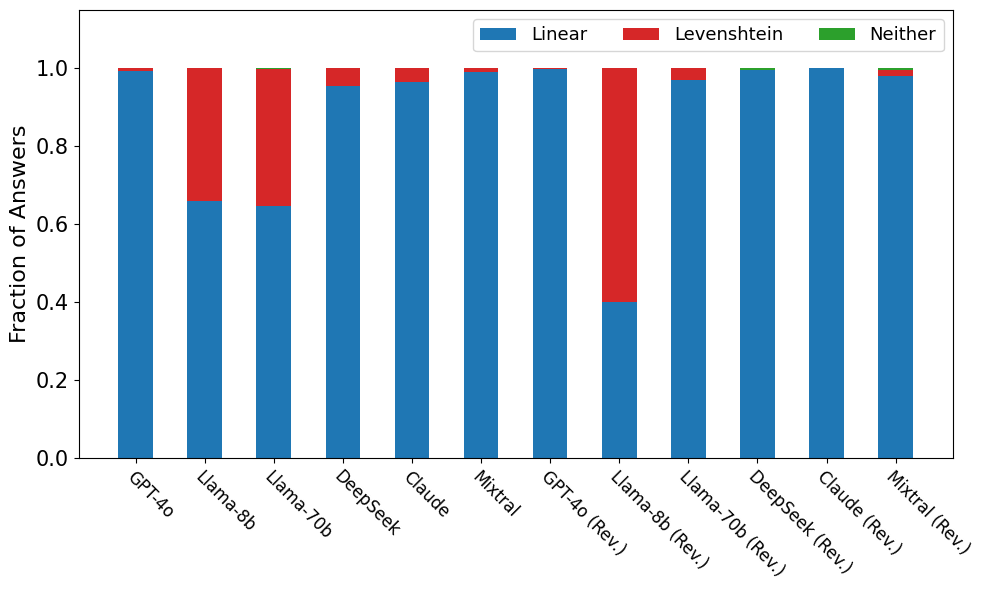

In [242]:
conditions = [key for key in triplet_fraction_summary_med_5dig.keys()]

weight_counts = {
    "Linear": np.array([triplet_fraction_summary_med_5dig[key]["Linear"] for key in conditions]),
    "Levenshtein": np.array([triplet_fraction_summary_med_5dig[key]["Levenshtein"] for key in conditions]),
    "Neither": np.array([triplet_fraction_summary_med_5dig[key]["Neither"] for key in conditions])
}

TYPE_TO_COLOR = {
    "Linear": "tab:blue",
    "Levenshtein": "tab:red",
    "Neither": "tab:green"
    
}

width = 0.5

fig, ax = plt.subplots(figsize=(10, 6))
bottom = np.zeros(len(conditions))

for measure, weight_count in weight_counts.items():
    p = ax.bar(conditions, weight_count, width, label=measure, bottom=bottom, color = TYPE_TO_COLOR[measure])
    bottom += weight_count

ax.set_ylabel("Fraction of Answers", fontsize=16)
ax.legend(loc="upper right", fontsize=13, ncol = 3)
ax.set_ylim([0, 1.15])
ax.tick_params(axis="both", labelsize=15)

ax.set_xticklabels(conditions, rotation=-45, ha='left', rotation_mode='anchor', fontsize=12)
plt.tight_layout()
# plt.savefig("final_plots/triplet_analysis_llm.pdf")

### Merged 3dig + 5dig Plot

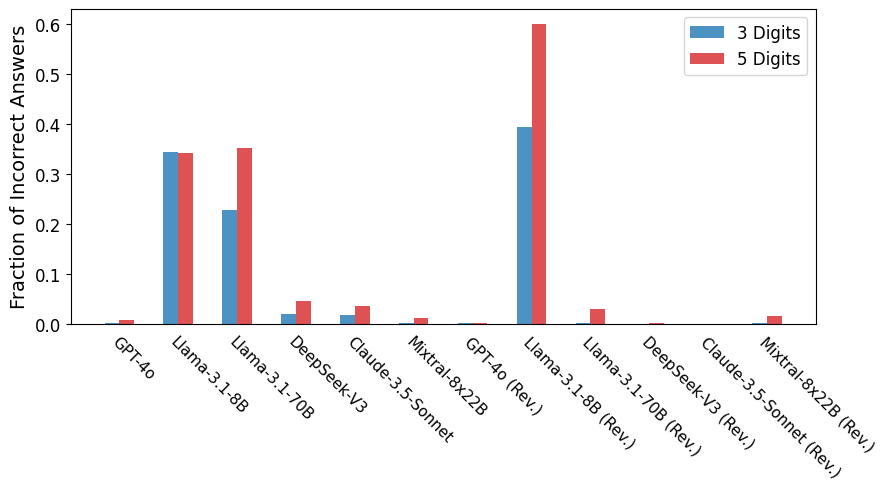

In [315]:
width = 0.25

fig, ax = plt.subplots(figsize=(9, 5))

loc_vals = np.arange(len(conditions))

weight_counts_3dig = np.array([triplet_fraction_summary_med[key]["Levenshtein"] for key in conditions])
weight_counts_5dig = np.array([triplet_fraction_summary_med_5dig[key]["Levenshtein"] for key in conditions])


ax.bar(loc_vals, weight_counts_3dig,
        align='center', alpha=0.8, ecolor='black', capsize=10, width=width, label="3 Digits", color="tab:blue")
ax.set_xticks(np.array(loc_vals) + width / 2);

ax.bar(loc_vals + width, weight_counts_5dig,
        align='center', alpha=0.8, ecolor='black', capsize=10, width=width, label="5 Digits", color="tab:red")

FULL_NAMES_v2 = {
    'GPT-4o': 'GPT-4o',
    'Llama-8b': 'Llama-3.1-8B',
    'Llama-70b': 'Llama-3.1-70B',
    'DeepSeek': 'DeepSeek-V3',
    'Claude': 'Claude-3.5-Sonnet',
    'Mixtral': 'Mixtral-8x22B',
    'GPT-4o (Rev.)': 'GPT-4o (Rev.)',
    'Llama-8b (Rev.)': 'Llama-3.1-8B (Rev.)',
    'Llama-70b (Rev.)': 'Llama-3.1-70B (Rev.)',
    'DeepSeek (Rev.)': 'DeepSeek-V3 (Rev.)',
    'Claude (Rev.)': 'Claude-3.5-Sonnet (Rev.)',
    'Mixtral (Rev.)': 'Mixtral-8x22B (Rev.)',
    'Levenshtein': 'Levenshtein (Rev.)',
    'Linear': 'Linear'
}

labels = [FULL_NAMES_v2[key] for key in conditions]
ax.set_xticks(np.array(loc_vals) + width / 2);
ax.xaxis.set_ticks_position('none')
ax.legend(fontsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_xticklabels(labels, rotation=-45, ha='left', rotation_mode='anchor', fontsize=11);
ax.set_ylabel("Fraction of Incorrect Answers", fontsize=14)

plt.tight_layout()

# plt.savefig("final_plots/triplet_medical_judgments_v4.pdf", dpi=200)

# Other Number Bases

In [244]:
sim_mat_gpt_base4 = np.load("all_models/numbers_0_to_999_base4_batchAPI-0-gpt-4o-batch-0-1-BatchAPI.npy")
sim_mat_gpt_base8 = np.load("all_models/numbers_0_to_999_base8_batchAPI-0-gpt-4o-batch-0-1-BatchAPI.npy")

sim_mat_gpt_base4 = (sim_mat_gpt_base4 + np.transpose(sim_mat_gpt_base4)) / 2
sim_mat_gpt_base8 = (sim_mat_gpt_base8 + np.transpose(sim_mat_gpt_base8)) / 2

In [245]:
other_model_base4 = np.load("all_models/base-4.npy", allow_pickle=True).item()
other_model_base8 = np.load("all_models/base-8.npy", allow_pickle=True).item()

In [246]:
# Excluding extremely rare out of bound cases in Llama-70b
print("Base 4")
print("To Exclude")
print(np.sum(other_model_base4['llama-3.1-70b-instruct'] > 1))
print("Out of")
print(len(other_model_base4['llama-3.1-70b-instruct'].reshape((-1,))))

print()
print("Base 8")
print("To Exclude")
print(np.sum(other_model_base8['llama-3.1-70b-instruct'] > 1))
print("Out of")
print(len(other_model_base8['llama-3.1-70b-instruct'].reshape((-1,))))

other_model_base4['llama-3.1-70b-instruct'][other_model_base4['llama-3.1-70b-instruct'] > 1] = 0 # temp fix
other_model_base8['llama-3.1-70b-instruct'][other_model_base8['llama-3.1-70b-instruct'] > 1] = 0 # temp fix

Base 4
To Exclude
2
Out of
1000000

Base 8
To Exclude
7
Out of
1000000


In [247]:
for key in other_model_base4.keys():
    other_model_base4[key] = (other_model_base4[key] + np.transpose(other_model_base4[key])) / 2
    other_model_base8[key] = (other_model_base8[key] + np.transpose(other_model_base8[key])) / 2

In [248]:
import string
digs = string.digits + string.ascii_letters

def int2base(x, base):
    if x < 0:
        sign = -1
    elif x == 0:
        return digs[0]
    else:
        sign = 1

    x *= sign
    digits = []

    while x:
        digits.append(digs[x % base])
        x = x // base

    if sign < 0:
        digits.append('-')

    digits.reverse()

    return ''.join(digits)

In [249]:
dist_mat_lev4 = np.zeros((MAX_NUM + 1, MAX_NUM + 1))
dist_mat_lev8 = np.zeros((MAX_NUM + 1, MAX_NUM + 1))

for i in range(MAX_NUM + 1):
    for j in range(MAX_NUM + 1):
        dist_mat_lev4[i,j] = distance(int2base(i,4), int2base(j,4))
        dist_mat_lev8[i,j] = distance(int2base(i,8), int2base(j,8))

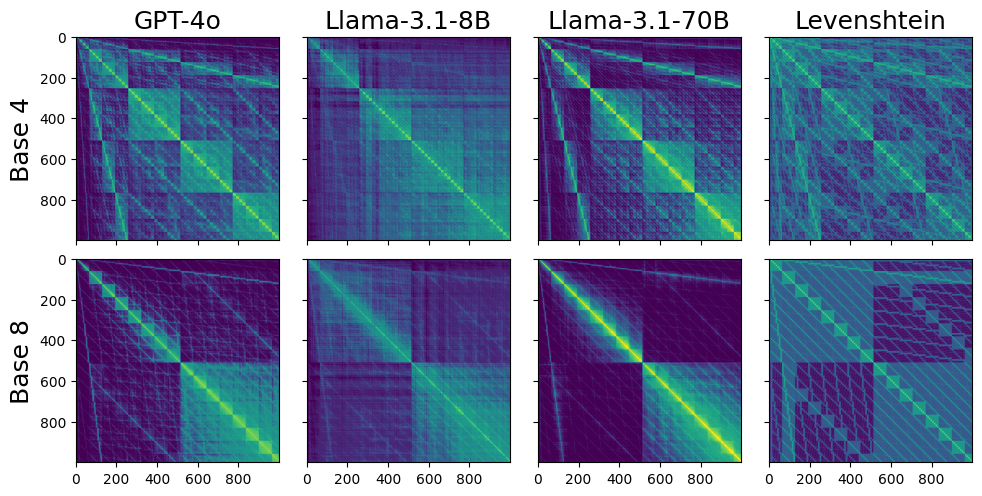

In [250]:
fig, axs = plt.subplots(2, 4, figsize=(10,5), sharex=True, sharey=True)

to_plot_gpt = {
    "Base 4": sim_mat_gpt_base4.copy(),
    "Base 8": sim_mat_gpt_base8.copy(),
    "Base 10": all_sim_mats["GPT-4o"].copy(),
}

to_plot_llama8b = {
    "Base 4": other_model_base4['llama-3.1-8b-instruct'],
    "Base 8": other_model_base8['llama-3.1-8b-instruct'],
    "Base 10": all_sim_mats['Llama-8b'].copy(),
}

to_plot_llama70b = {
    "Base 4": other_model_base4['llama-3.1-70b-instruct'],
    "Base 8": other_model_base8['llama-3.1-70b-instruct'],
    "Base 10": all_sim_mats['Llama-70b'].copy(),
}

to_plot_lev = {
    "Base 4": 1 - dist_mat_lev4.copy() / np.max(dist_mat_lev4),
    "Base 8": 1 - dist_mat_lev8.copy() / np.max(dist_mat_lev8),
    "Base 10": all_sim_mats["Levenshtein"].copy(),
}

for i, key in enumerate(to_plot_gpt.keys()):
    if key != "Base 10":
        axs[i,0].imshow(to_plot_gpt[key])
        axs[i,0].set_xticks(np.arange(0,1000,200))

axs[0,0].set_title(FULL_NAMES["GPT-4o"], fontsize=18)

for i, key in enumerate(to_plot_llama8b.keys()):
    if key != "Base 10":
        axs[i,1].imshow(to_plot_llama8b[key])
        axs[i,1].set_xticks(np.arange(0,1000,200))

axs[0,1].set_title(FULL_NAMES["Llama-8b"], fontsize=18)

for i, key in enumerate(to_plot_llama70b.keys()):
    if key != "Base 10":    
        axs[i,2].imshow(to_plot_llama70b[key])
        axs[i,2].set_xticks(np.arange(0,1000,200))

axs[0,2].set_title(FULL_NAMES["Llama-70b"], fontsize=18)

for i, key in enumerate(to_plot_lev.keys()):
    if key != "Base 10":  
        axs[i,3].imshow(to_plot_lev[key])
        axs[i,3].set_xticks(np.arange(0,1000,200))

axs[0,3].set_title(FULL_NAMES["Levenshtein"], fontsize=18)

axs[0,0].set_ylabel("Base 4", fontsize=18)
axs[1,0].set_ylabel("Base 8", fontsize=18)

plt.tight_layout()
# plt.savefig("final_plots/number_similarity_matrices_other_bases.pdf",dpi=300)

In [251]:
all_metrics_bases_gpt4 = {}
for key in to_plot_gpt.keys():
    all_metrics_bases_gpt4[key] = get_metric_regressors(to_plot_gpt[key], to_plot_lev[key], all_sim_mats["Linear"])

all_metrics_bases_llama8b = {}
for key in to_plot_llama8b.keys():
    all_metrics_bases_llama8b[key] = get_metric_regressors(to_plot_llama8b[key], to_plot_lev[key], all_sim_mats["Linear"])

all_metrics_bases_llama70b = {}
for key in to_plot_llama70b.keys():
    all_metrics_bases_llama70b[key] = get_metric_regressors(to_plot_llama70b[key], to_plot_lev[key], all_sim_mats["Linear"])

In [252]:
all_metrics_bases_gpt4_boots = {}
for key in to_plot_gpt.keys():
    all_metrics_bases_gpt4_boots[key] = get_metric_regressors_bootstrap(to_plot_gpt[key], to_plot_lev[key], all_sim_mats["Linear"])

all_metrics_bases_llama8b_boots = {}
for key in to_plot_llama8b.keys():
    all_metrics_bases_llama8b_boots[key] = get_metric_regressors_bootstrap(to_plot_llama8b[key], to_plot_lev[key], all_sim_mats["Linear"])

all_metrics_bases_llama70b_boots = {}
for key in to_plot_llama70b.keys():
    all_metrics_bases_llama70b_boots[key] = get_metric_regressors_bootstrap(to_plot_llama70b[key], to_plot_lev[key], all_sim_mats["Linear"])


In [253]:
# np.save("data/similarity_bases_gpt4_loglin.npy", all_metrics_bases_gpt4_boots, allow_pickle=True)
# np.save("data/similarity_bases_llama8b_loglin.npy", all_metrics_bases_llama8b_boots, allow_pickle=True)
# np.save("data/similarity_bases_llama70b_loglin.npy", all_metrics_bases_llama70b_boots, allow_pickle=True)

In [311]:
current_item = all_metrics_bases_gpt4_boots["Base 4"]["rsq_solo_lin"]
# np.mean(current_item) - 1.96 * np.std(current_item)
# np.mean(current_item) + 1.96 * np.std(current_item)

0.299350663451786

In [313]:
current_item = all_metrics_bases_gpt4_boots["Base 4"]["rsq_solo_lev"]
# np.mean(current_item) - 1.96 * np.std(current_item)
# np.mean(current_item) + 1.96 * np.std(current_item)

0.4284875293249205

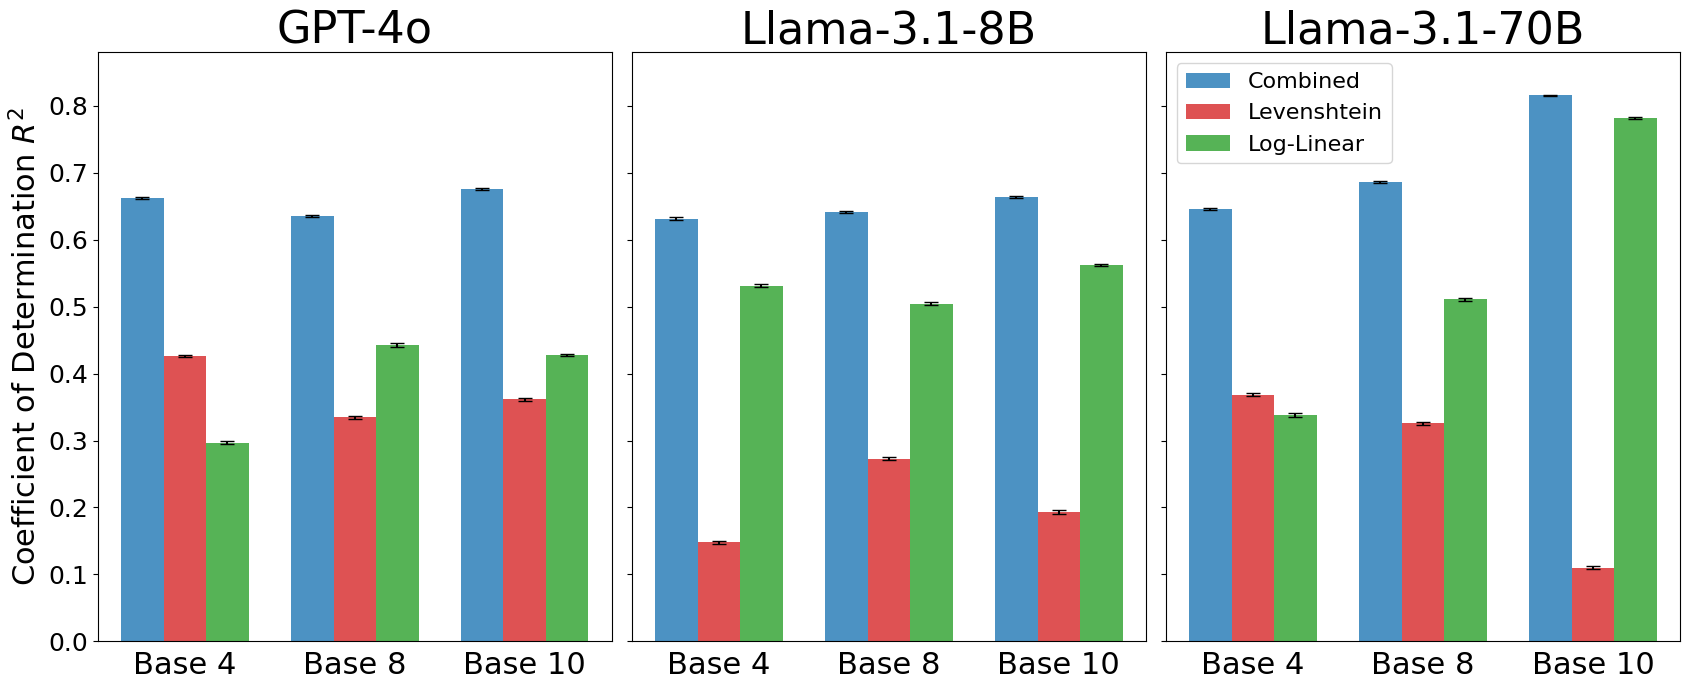

In [266]:
width = 0.25

fig, axs = plt.subplots(1, 3 ,figsize=(17, 7),sharey=True)

metric_list = [
    all_metrics_bases_gpt4_boots,
    all_metrics_bases_llama8b_boots,
    all_metrics_bases_llama70b_boots
]

for i, current_metrics in enumerate(metric_list):
    all_model_keys = [key for key in current_metrics.keys()]
    all_rsq = [np.mean(current_metrics[key]["rsq_list"]) for key in current_metrics.keys()]
    all_rsq_solo_lin = [np.mean(current_metrics[key]["rsq_solo_lin"]) for key in current_metrics.keys()]
    all_rsq_solo_lev = [np.mean(current_metrics[key]["rsq_solo_lev"]) for key in current_metrics.keys()]

    all_rsq_ci = [1.96 * np.std(current_metrics[key]["rsq_list"]) for key in current_metrics.keys()]
    all_rsq_solo_lin_ci = [1.96 * np.std(current_metrics[key]["rsq_solo_lin"]) for key in current_metrics.keys()]
    all_rsq_solo_lev_ci = [1.96 * np.std(current_metrics[key]["rsq_solo_lev"]) for key in current_metrics.keys()]
    
    loc_vals = np.arange(len(all_rsq))
    
    weight_counts_rsq_full = np.array(all_rsq)
    weight_counts_rsq_lev = np.array(all_rsq_solo_lev)
    weight_counts_rsq_lin = np.array(all_rsq_solo_lin)
    
    axs[i].bar(loc_vals, weight_counts_rsq_full, yerr = all_rsq_ci,
            align='center', alpha=0.8, ecolor='black', capsize=5, width=width, label="Combined", color="tab:blue")
    axs[i].set_xticks(np.array(loc_vals) + width / 2);
    
    axs[i].bar(loc_vals + width, weight_counts_rsq_lev, yerr = all_rsq_solo_lev_ci,
            align='center', alpha=0.8, ecolor='black', capsize=5, width=width, label="Levenshtein", color="tab:red")
    
    axs[i].bar(loc_vals + 2 * width, weight_counts_rsq_lin, yerr = all_rsq_solo_lin_ci,
            align='center', alpha=0.8, ecolor='black', capsize=5, width=width, label="Log-Linear", color="tab:green")
    
    labels = all_model_keys
    axs[i].set_xticks(np.array(loc_vals) + width);
    axs[i].xaxis.set_ticks_position('none')
    # axs[i].set_xticklabels(labels, rotation=-45, ha='left', rotation_mode='anchor', fontsize=19);
    axs[i].tick_params(axis="both", labelsize=18)
    axs[i].set_xticklabels(labels, fontsize=22);
    axs[i].set_ylim([0,0.88])

axs[0].set_ylabel(r"Coefficient of Determination $R^2$", fontsize=22)
axs[2].legend(ncol=1, fontsize=16, loc="upper left")
axs[0].set_title(FULL_NAMES["GPT-4o"], fontsize=32)
axs[1].set_title(FULL_NAMES["Llama-8b"], fontsize=32)
axs[2].set_title(FULL_NAMES["Llama-70b"], fontsize=32)

plt.tight_layout()
# plt.savefig("final_plots/other_bases_rsq_loglin.pdf")

# Visualizing Probe Matrices

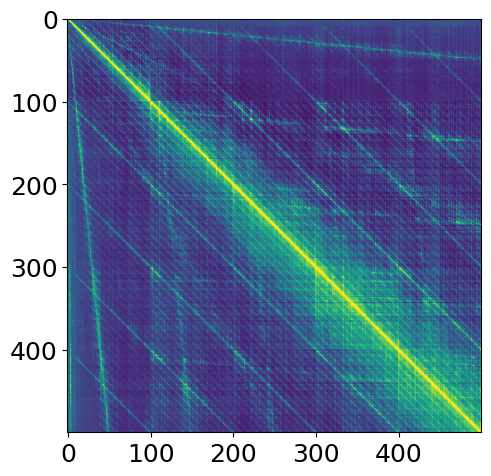

In [261]:
int_probe = np.load("all_models/sim_matrix_probe_int_loglin.pkl", allow_pickle=True)
str_probe = np.load("all_models/sim_matrix_probe_string_loglin.pkl", allow_pickle=True)

fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.imshow(str_probe, vmax=0.6)
ax.tick_params(axis="both", labelsize=18)
plt.tight_layout()
# plt.savefig("final_plots/probe_string_loglin.pdf", dpi=300)

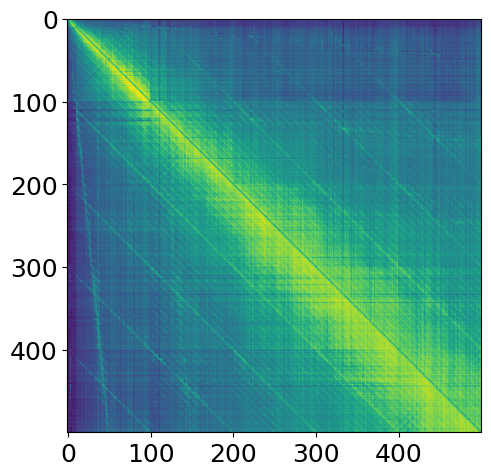

In [262]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.imshow(int_probe)
ax.tick_params(axis="both", labelsize=18)
plt.tight_layout()
# plt.savefig("final_plots/probe_int_loglin.pdf", dpi=300)